In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### **Dataset**

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-13 15:58:59--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: 'course_lead_scoring.csv'

     0K .......... .......... .......... .......... .......... 63%  983K 0s
    50K .......... .......... ........                        100% 7.70M=0.05s

2025-10-13 15:59:00 (1.41 MB/s) - 'course_lead_scoring.csv' saved [80876/80876]



### **Preparing the dataset**

In [2]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
# Check if the missing values are presented in the features.
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
df[['lead_source', 'industry', 'employment_status', 'location']] = df[['lead_source', 'industry', 'employment_status', 'location']].fillna('NA')
df['annual_income'] = df['annual_income'].fillna(0.0)

In [5]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

### **Question 1**

What is the most frequent observation (mode) for the column education?

In [6]:
mode_industry = df['industry'].mode()[0]
print(f"The most frequent observation for the column industry: {mode_industry}")

The most frequent observation for the column industry: retail


### **Question 2**

Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

In [7]:
numerical_features = df.select_dtypes(include='number').columns

corr_matrix = df[numerical_features].corr().round(2)
corr_matrix

,number_of_courses_viewed,annual_income,interaction_count,lead_score,converted
number_of_courses_viewed,1.00,0.01,-0.02,-0.00,0.44
annual_income,0.01,1.00,0.03,0.02,0.05
interaction_count,-0.02,0.03,1.00,0.01,0.37
lead_score,-0.00,0.02,0.01,1.00,0.19
converted,0.44,0.05,0.37,0.19,1.00


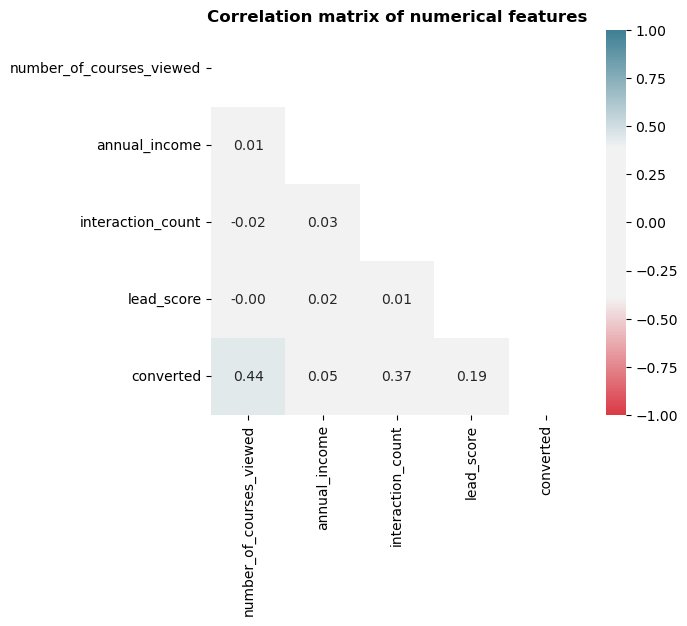

In [8]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True, sep=100)

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, vmin=-1, vmax=1, center=0, mask=mask)
plt.title('Correlation matrix of numerical features', fontweight='bold')

plt.show()

### **Split the data**

- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value y is not in your dataframe.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

print(f"Train distribution: {len(df_train)}")
print(f"Validation distribution: {len(df_val)}")
print(f"Test distribution: {len(df_test)}")
print(f"Total distribution: {len(df)}")

Train distribution: 876
Validation distribution: 293
Test distribution: 293
Total distribution: 1462


In [50]:
features = [*df.columns[:-1]]
target = df.columns[-1]

In [11]:
# reset the index of datasets
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [ ]:
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

In [52]:
df_train = df_train[features]
df_val = df_val[features]
df_test = df_test[features]

### **Question 3**

- Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).

Which of these variables has the biggest mutual information score?

In [53]:
from sklearn.metrics import mutual_info_score

In [54]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, y_train)

In [55]:
categorical_features = [*df_train.select_dtypes(include='object').columns]

mi = df_train[categorical_features].apply(mutual_info_churn_score).round(2)
mi.sort_values(ascending=False)

lead_source          0.04
industry             0.01
employment_status    0.01
location             0.00
dtype: float64

In [56]:
biggest_mi = mi[mi.max() == mi.values].index[0]

print(f"The biggest mutual information score: {biggest_mi}")

The biggest mutual information score: lead_source


### **Question 4**

- Now let's train a logistic regression.
- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
- To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
- model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [58]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the OneHotEncoder on the combined dataset
ohe.fit(df_train)

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [68]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the OneHotEncoder on the combined dataset
ohe.fit(df_train[categorical_features])

# Transform each dataset using the fitted encoder
ohe_train = ohe.transform(df_train[categorical_features])
ohe_val = ohe.transform(df_val[categorical_features])
ohe_test = ohe.transform(df_test[categorical_features])

# Stack the categorical columns with the numerical columns
X_train = np.column_stack([ohe_train, df_train[numerical_features[:-1]].values])
X_val = np.column_stack([ohe_val, df_val[numerical_features[:-1]].values])
X_test = np.column_stack([ohe_test, df_test[numerical_features[:-1]].values])

In [72]:
X_train.shape, X_val.shape, X_test.shape

((876, 31), (293, 31), (293, 31))

In [73]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [74]:
y_predict = model.predict(X_val)

df_pred = pd.DataFrame()
df_pred['prediction'] = y_predict
df_pred['actual'] = y_val
df_pred['correct'] = df_pred['prediction'] == df_pred['actual']
df_pred.head()

,prediction,actual,correct
0,1,0,False
1,1,1,True
2,1,0,False
3,0,0,True
4,1,0,False


In [75]:
# calculate the accuracy
accuracy = df_pred['correct'].mean().round(2)
print(f"The accuracy of the model on validation dataset: {accuracy}")

The accuracy of the model on validation dataset: 0.7


### **Question 5**

- Let's find the least useful feature using the feature elimination technique.
- Train a model with all these features (using the same parameters as in Q4).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?

In [76]:
features = ['industry', 'employment_status', 'lead_score']
scores = {}

score_initial = accuracy

for f in features:
    # Copy the original dataframes to avoid altering them
    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()

    # Create a copy of numerical_columns and remove the current feature if it exists in the copy
    numerical_features_copy = [*numerical_features[:-1].copy()]
    if f in numerical_features_copy:
        numerical_features_copy.remove(f)

    # Stack the categorical columns with the remaining numerical columns
    X_train = np.column_stack([ohe_train, df_train_copy[numerical_features_copy].values])
    X_val = np.column_stack([ohe_val, df_val_copy[numerical_features_copy].values])

    # Fit the logistic regression model without the current feature
    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Use the model to predict the validation dataset
    y_pred_val = model.predict_proba(X_val)[:, 1]
    churn_decision = (y_pred_val >= 0.5)

    # Calculate the accuracy for the model without the current feature
    score = (churn_decision == y_val).mean()

    # Calculate the difference in accuracy
    score_difference = score_initial - score

    # Store the score difference in the dictionary
    scores[f] = np.abs(score_difference)

# Print the score differences for each feature
for feature, score_diff in scores.items():
    print(f"Feature: {feature}, Accuracy Difference: {score_diff}")

Feature: industry, Accuracy Difference: 0.0003412969283276279
Feature: employment_status, Accuracy Difference: 0.0003412969283276279
Feature: lead_score, Accuracy Difference: 0.006484641638225264


### **Question 6**

- Now let's train a regularized logistic regression.
- Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
- Train models using all the features as in Q4.
- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these C leads to the best accuracy on the validation set?

In [77]:
C_values = [0.01, 0.1, 1, 10, 100]
accuracy_scores = {}

for c in C_values:
    model = LogisticRegression(solver='liblinear', C=c, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    accuracy = (y_pred == y_val).mean().round(3)

    accuracy_scores[c] = accuracy

    print(f"Accuracy with C: {c} is {accuracy}")

Accuracy with C: 0.01 is 0.696
Accuracy with C: 0.1 is 0.7
Accuracy with C: 1 is 0.706
Accuracy with C: 10 is 0.706
Accuracy with C: 100 is 0.706


In [78]:
best_accuracy = max(accuracy_scores, key=accuracy_scores.get)
print(f"The C value that has the best accuracy: {best_accuracy}")

The C value that has the best accuracy: 1
